# Logistic regression: intuitive explanation

From hockey sticks\

## What IS NOT a logistic regression?

Let us go over some "common" misconceptions first out of the way. Logistic regression is not:

- sigmoid curve fit through a set of points such that the difference between points and the curve is minimal
- classification algorithm
- curve that serves as a boundary to separate two classes of points in the x-y plane 

![Image of not logistic regressions](../images/not_a_logit.png)

## What IS a logistic regression?

Logistic regression is a regression model that returns a probability of a binary outcome (0 or 1), assuming that log of the odds-ratio is a linear combination of one or more inputs. Odds ratio is ratio between probability of outcome happening (1) and the probability of the outcome not happening (0). When we have one input/predictor, this starting assumption is mathematically expressed as:

$$\log\frac{p}{1-p} = \beta_1 x + \beta_0$$

The goal behind logistic regression is to model cases when the input(s) are affecting the outcome in a probabilistic way. This outcome probability is assumed to be an S-shaped curve that can be expressed with the following mathematical equation:

$$p(x) = \frac{1}{1 + e^{-(\beta_1 x + \beta_0)}}= \frac{1}{1 + e^{-k(x - x_0)}}$$

where we swapped from $\beta_1$ and $\beta_0$ to $k$ and $x_0$ as parameters, for the purposes of understading them using plots.

## Logistic curve

Let us plot the curve first, for example with $x_0 = 2.5$ and $k = 3$:

In [141]:
import warnings
warnings.filterwarnings('ignore') # for tidyer TDS post

In [118]:
import numpy as np
import pandas as pd
import plotnine as p9

from scipy.stats import uniform, bernoulli

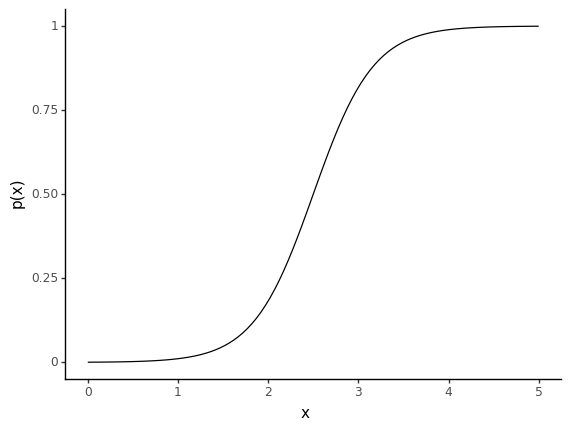

<ggplot: (8758490167053)>

In [119]:
def logistic(x, k, x0):
    return 1 / (1 + np.exp(-k*(x - x0)))

def create_smooth_logistic_curve_data(k, x0, n_points=100):
    df = pd.DataFrame({
        'x': np.linspace(0, 5, n_points)
    })
    df['p_x'] = logistic(df['x'], k, x0)
    return df

def plot_smooth_logistic_curve(k, x0, n_points=100):
    df = create_smooth_logistic_curve_data(k, x0, n_points)
    return (
        p9.ggplot(df, p9.aes('x', 'p_x'))
	    + p9.geom_line()
        + p9.scale_y_continuous(name='p(x)')
        + p9.theme_classic()
    )

plot_smooth_logistic_curve(3, 2.5)

The meaning of these two parameters is:
- $x_0$ is the value of a predictor x for which the probability is 0.5 (mid-point): $p(x = x_0) = 0.5$, so tells us about the location of the mid-point.
- $k$ is related to the slope of the probability at mid-point: $(dp/dx)_{x = x_0} = k/4$, so tells us about the steepness of the curve at that mid-point. The larger the $k$, the steeper the curve.

## Naïve least-square fit

As mentioned earlier, the fitting process in logistic regression is different than in linear regression. In linear regression, ordinary least square approach takes _vertical differences between the predicted line and data points_ (residuals), squares them, then adds them up.

What if we tried the same here anyway?

Let us add some points to the previous plot to see if this would work or make sense here:

In [120]:
def create_sample_data(k, x0, n_points, seed=1):
    np.random.seed(seed)
    df = pd.DataFrame({
        'x': uniform.rvs(loc=0, scale=5, size=n_points)
    }).sort_values('x', ignore_index=True)
    df['p_x'] = logistic(df['x'], k, x0)
    df['y'] = bernoulli.rvs(df['p_x'])
    return df

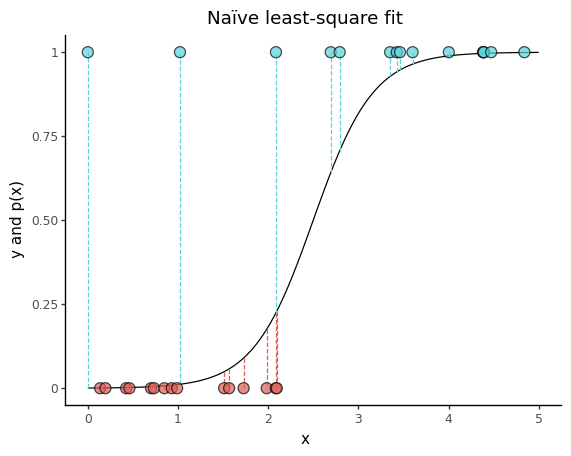

<ggplot: (8758490315406)>

In [121]:
def plot_naive_logistic_fit(k, x0, n_data_points):
    sample_df = create_sample_data(k, x0, n_data_points)
    sample_df.loc[0, 'y'] = 1 # manually add an outlier
    curve_df = create_smooth_logistic_curve_data(k, x0)
    return (
        p9.ggplot(sample_df, p9.aes('x'))
	    + p9.geom_line(
            data=curve_df,
            mapping=p9.aes(y='p_x')
        )
        + p9.geom_linerange(
            mapping=p9.aes(ymin='p_x', ymax='y', color='factor(y)'),
            linetype='dashed'
        )
        + p9.geom_point(
            mapping=p9.aes(y='y', fill='factor(y)'),
            size=4,
            alpha=0.7,
            shape='o'
        )
        + p9.scale_y_continuous(name='y and p(x)')
        + p9.labels.ggtitle('Naïve least-square fit')
        + p9.theme_classic()
        + p9.theme(legend_position='none')
    )

plot_naive_logistic_fit(3, 2.5, n_data_points=30)

Here, we colored the points at $y = 0$ in <font color="#db5f57">red</font> and points at $y = 1$ in <font color="#57d3db">teal</font>.

One of the immediate problems is that the residual of each point is always less than 1 (the upper bound). Because of this, the left-most top 3 points (for $y = 1$) have almost the same residuals. However, it would make more sense to assign a much larger cost to the first teal point that appears at $x=0$ than to the second one at $x = 1.2$.

## Log-loss fit

Then, what is the approach employed by logistic regression?

* For the <font color="#57d3db">teal</font> points at $y=1$, one way to create a (positive) larger cost at $x=0$ is to take the (negative) logarithm of the fitted probability, $-\log p(x)$.
* For the <font color="#db5f57">red</font> points at $y=0$ we can do the same for the inverted probability, $-\log[1-p(x)]$.

We will call these "log-losses" - for each point $x$ they give us a *cost* of that point being away from the fitted curve. In order to utilize `numpy` vectorization, we will code these two together as a single loss function:

$$\mathrm{log-loss} = -y\log p(x) - (1-y)\log[1 - p(x)]$$

* When $y=0$, the first term is zero and the log-loss is equal to $-\log[1 - p(x)]$.
* When $y=1$, the second term is zero, and the log-loss is $-\log p(x)$.

So writing this way is the same as specifying separate functions for each $y$. This combo expression is also called "cross-entropy" and has an another interpretation in information theory that we will not go into at the moment.

Logistic model fits these two functions simultaneously: $-\log p(x)$ for $y=1$ and $-\log[1 - p(x)]$ for $y=0$. We will collapse all the data points to $y=0$ and plot each of these log-losses separately, to get a better intuition what is happening.

As an example, we will again generate 30 data points, with $k=3$ and $x_0=2.5$ and fit them to the log-losses with same parameters for the illustrative purposes:

In [122]:
def log_loss(p_x, y):
    return -y * np.log(p_x) - (1 - y) * np.log(1 - p_x)

In [123]:
def create_smooth_logloss_data(k, x0, n_points=100):
	x = np.linspace(0, 5, n_points)
	p_x = logistic(x, k, x0)
	return pd.DataFrame({
		'x': np.concatenate((
			x,
			x
		)),
		'y': np.concatenate((
			[0] * len(x),
			[1] * len(x)
		)),
		'log_loss': np.concatenate((
			log_loss(p_x, 0),
			log_loss(p_x, 1)
		)),
	})

In [124]:
def plot_logistic_fit(df, logloss_df):
	return (
		p9.ggplot(df, p9.aes('x'))
		+ p9.geom_line(
			data=logloss_df,
			mapping=p9.aes(y='log_loss', color='factor(y)'),
		)
		+ p9.geom_linerange(
		    mapping=p9.aes(ymin=0, ymax='log_loss', color='factor(y)'),
		    linetype='dashed',
		)
		+ p9.geom_point(
			mapping=p9.aes(y=0, fill='factor(y)'),
			size=4,
			alpha=0.7,
			shape='o',
		)
		+ p9.scale_y_continuous(name='log loss')
		# + p9.labels.ggtitle("Total log-loss: " + str(np.sum(df['log_loss'])))
		+ p9.theme_classic()
		+ p9.theme(legend_position='none')		
	)

def create_sample_and_logloss_data(k, x0, k_fit, x0_fit, n_points, seed=1):
	df = create_sample_data(k, x0, n_points, seed)
	df['p_x_fit'] = logistic(df['x'], k_fit, x0_fit)
	df['log_loss'] = log_loss(df['p_x_fit'], df['y'])
	logloss_df = create_smooth_logloss_data(k_fit, x0_fit)
	return (df, logloss_df)

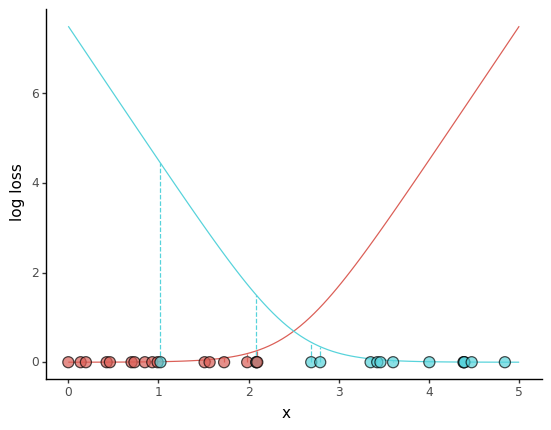

<ggplot: (8758497156446)>

In [125]:
df, logloss_df = create_sample_and_logloss_data(
	k=3,
	x0=2.5,
	k_fit=3,
	x0_fit=2.5,
	n_points=30,
)

plot_logistic_fit(df, logloss_df)

The fitting process is:

* <font color="#db5f57">Red points</font> ($y=0$) are fit to the <font color="db5f57">red "hockey stick" curve</font>: $-\log[1-p(x)]$
* <font color="#57d3db">Teal points</font> ($y=1$) are fit to the <font color="#57d3db">teal "hockey stick" curve</font>: $-\log p(x)$
* Both of these curves share the same parameters $k$ and $x_0$, so they change together
* Sum of the vertical displacements between points is the total cost (or log-loss) that needs to be minimzed for various combinations of $k$ and $x_0$

$$\mathrm{total log-loss} = - \sum_{i=1}^{n_{points}}\left[y_i \log p(x_i) + (1 - y_i)\log(1-p(x_i)) \right]$$

Unlike ordinary least-square method for linear regression, minimizing this function does not have an analytical solution in the form of an exact mathematical formula. The minimization of log-loss is done numerical methods or by using a maximum likelihood estimation, which is outside of the scope of this post but happens to be equivalent to minimizing this exact log-loss.

## Finding the minimal log-loss

How does changing $k$ and $x_0$ affect this fit?

In [126]:
params = {
    'x0': [1.5, 2.5, 3.5] + [2.5, 2.5, 2.5],
    'k': [3, 3, 3] + [1, 3, 7]
}

def create_sample_and_logloss_data_from_params(params):
    df_list = []
    logloss_df_list = []
    for x0, k in zip(params['x0'], params['k']):
        df, logloss_df = create_sample_and_logloss_data(
            k=3,
            x0=2.5,
            k_fit=k,
            x0_fit=x0,
            n_points=30
        )
        df['x0_fit'] = logloss_df['x0_fit'] = x0
        df['k_fit'] = logloss_df['k_fit'] = k
        df_list.append(df)
        logloss_df_list.append(logloss_df)

    dfs = pd.concat(df_list, ignore_index=True)
    logloss_dfs = pd.concat(logloss_df_list, ignore_index=True)
    return (dfs, logloss_dfs)

First, we can check that changing $x_0$ again just moves the intersection point left or right:

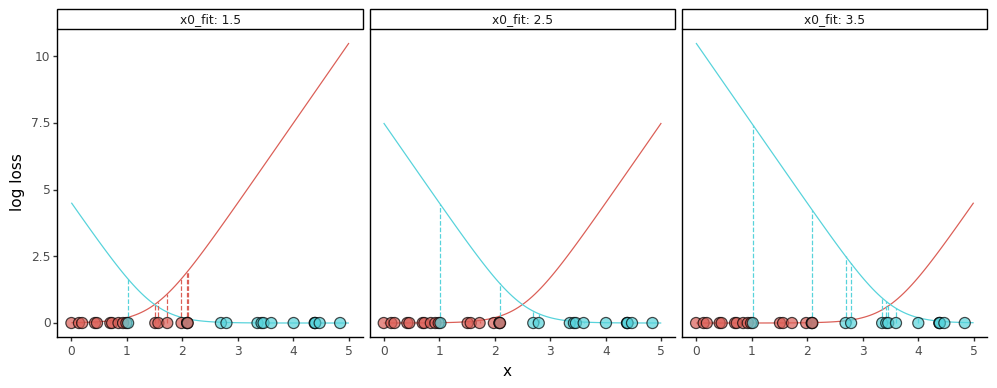

<ggplot: (8758490772649)>

In [127]:
x0_dfs, x0_logloss_dfs = create_sample_and_logloss_data_from_params({
    'x0': [1.5, 2.5, 3.5],
    'k': [3, 3, 3]
})

x0_changing_plot = plot_logistic_fit(x0_dfs, x0_logloss_dfs)
x0_changing_plot += p9.facet_wrap('~x0_fit', labeller='label_both') 
x0_changing_plot += p9.theme(figure_size=(12, 4))
x0_changing_plot

So, if $x_0$ is chosen far away from the optimal point, the log-loss increases because increasing number of points gets fitted to the rising parts of the "hockey stick".

Next, notice that changing $k$ changes the sharpness of the "hockey stick" log-loss curves (note the y axis span in each plot):

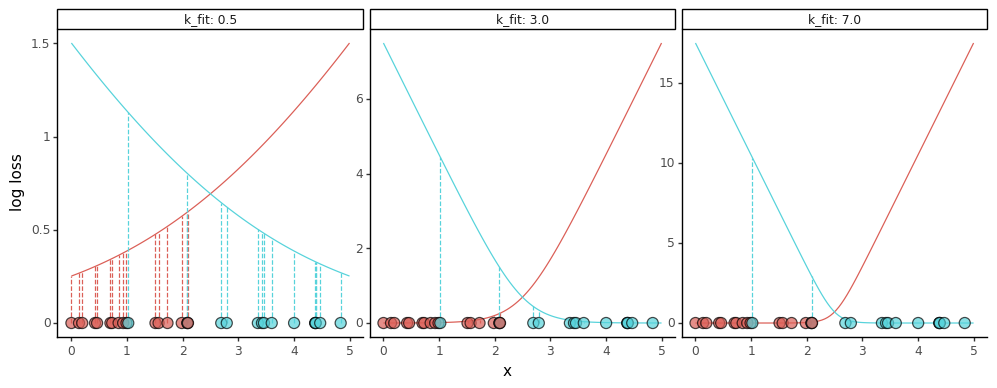

<ggplot: (8758490732810)>

In [128]:
k_dfs, k_logloss_dfs = create_sample_and_logloss_data_from_params({
    'x0': [2.5, 2.5, 2.5],
    'k': [0.5, 3, 7]
})

k_changing_plot = plot_logistic_fit(k_dfs, k_logloss_dfs)
k_changing_plot += p9.facet_wrap('~k_fit', labeller='label_both', scales='free_y') 
k_changing_plot += p9.theme(figure_size=(12, 4), subplots_adjust={'wspace': 0.02})
k_changing_plot

* If $k$ is too low (0.5), the log-loss looks almost linear. Most points have add a small but significant amount to the total log-loss. 
* If $k$ is too high (7), most points on the "correct side" of $x = 2.5$ add a negligible amount to the total log-loss but few points on the "wrong side" will add a large amount to the total log-loss.

The total log-loss for each parameter $k = \{0.5, 3, 7\}$ is:

In [129]:
k_dfs.groupby('k_fit')['log_loss'].sum()

k_fit
0.5    13.550052
3.0     7.933129
7.0    13.791910
Name: log_loss, dtype: float64

and similarly for $x_0 = \{1.5, 2.5, 3.5\}$:

In [130]:
x0_dfs.groupby('x0_fit')['log_loss'].sum()

x0_fit
1.5    10.796461
2.5     7.933129
3.5    20.002475
Name: log_loss, dtype: float64

## Running the logistic model

Of course, in practice the algorithms for finding the optimal parameters are built into R/Python. We will use Python's `statsmodels` library. Just keep in mind: functions in these libraries parametrize the probability using $\beta$ s instead of $k$ and $x_0$ we used:

$$p(x) = \frac{1}{1 + e^{-k(x - x_0)}} = \frac{1}{1 + e^{-(\beta_1 x + \beta_0)}}$$

where the relationship between $k, x_0$ and $\beta_1, \beta_0$ is:

$$\beta_1 = k,\quad \beta_0 = - kx_0$$

so our model with $k=3$ and $x_0=2.5$ translates to $\beta_1=3$ and $\beta_0=-7.5$:

In [131]:
import statsmodels.formula.api as smf
model = smf.logit('y ~ x', df).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.230366
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   30
Model:                          Logit   Df Residuals:                       28
Method:                           MLE   Df Model:                            1
Date:                Sun, 14 May 2023   Pseudo R-squ.:                  0.6666
Time:                        20:49:07   Log-Likelihood:                -6.9110
converged:                       True   LL-Null:                       -20.728
Covariance Type:            nonrobust   LLR p-value:                 1.466e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.6829      2.196     -2.588      0.010      -9.986      -1.380
x              2.6187      1.025      2.554      0.011       0.609       4.628
==============================================================================
"""

Since we have very few data points and because the seed was chosen to showcase an example with outliers, the fit is not perfect, but we can read out the model parameters:

$$\beta_1 = 2.6187, \quad \beta_0 = -5.6829$$

and the total log-loss is here reported as "Log-Likelihood", which is just negative total log-loss and equals -6.911.

## Limitations of logistic regression

Since the parameters of the logistic model are obtained numerically (commonly using maximum likelihood estimation), this process can fail to converge for a number of reasons, such as:

1. large number of predictors $x_i$ compared to the number of samples
2. predictors that have high or perfect correlations
3. categorical predictors that contain a lot of missing categories
4. perfect separation 😮

Issues 1. and 2. can be corrected using various regularization methods or taking out problematic predictors from the model. Issue 3. can be fixed by re-grouping categories or in some other way filling in missing categories. Issue 4., perfect separation, is another cause for non-convergence, and an Achilles' heel of a logistic regression. It is difficult to resolve it directly - without switching to Bayesian logistic regression, so it warrants further discussion.

### Perfectly separated data

By definition, logistic model cannot fit data that is perfectly separated! We can apply what we learned earlier about model fitting to understand why perfectly seprated data cannot be represented using logistic model. Start with creating perfectly separated data and show the exact fit (we again chose $k=3$ and $x_0=2.5$):

In [132]:
def create_perfectly_sep_data_and_logloss(k, x0, n_points, seed=1):
    np.random.seed(seed)
    perfect_sep_data = pd.DataFrame({
        'x': np.concatenate((
            uniform.rvs(loc=0, scale=2.5, size=n_points // 2),
            uniform.rvs(loc=2.5, scale=2.5, size=n_points // 2)
        )),
        'y': np.concatenate((
            [0] * (n_points // 2),
            [1] * (n_points // 2)
        ))
    }).sort_values('x', ignore_index=True)
    perfect_sep_data['p_x'] = logistic(perfect_sep_data['x'], k, x0)
    perfect_sep_data['log_loss'] = log_loss(perfect_sep_data['p_x'], perfect_sep_data['y'])

    logloss_df = create_smooth_logloss_data(k, x0)
    return (perfect_sep_data, logloss_df)

Total log-loss:  3.282022354606257


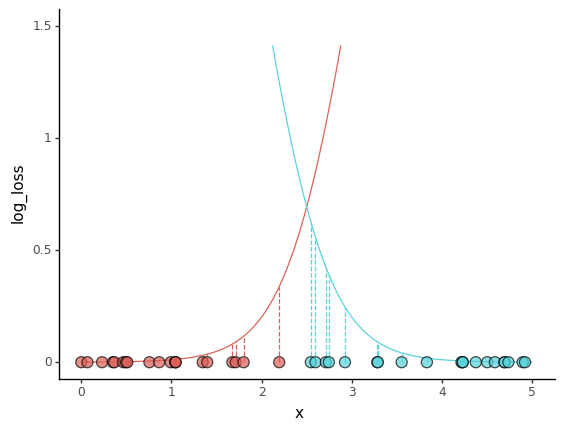

<ggplot: (8758491043112)>

In [133]:
perfect_sep_data, logloss_df = create_perfectly_sep_data_and_logloss(
    k=3,
    x0=2.5,
    n_points=40,
)

print("Total log-loss: ", perfect_sep_data['log_loss'].sum())

logistic_plot = plot_logistic_fit(perfect_sep_data, logloss_df)
logistic_plot += p9.ylim(0, 1.5)
logistic_plot

Remember how changing $k$ affects these "hockey stick" log-loss curves?

The higher the $k$, the better log-loss curves fit the points on the "correct" side of the mid-point - red points on the left and teal points on the right. However, unlike in the previous case, now there are no points on the "wrong" side of the mid-point! These fits can just get better and better without limit or any penalty to continuously increasing $k$.

Here is how the fits look when we set $k = 15$:

Total log-loss:  0.6930512657440677


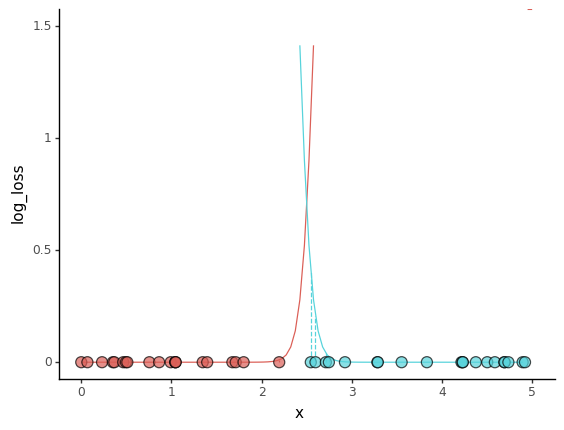

<ggplot: (8758489886151)>

In [138]:
perfect_sep_data, logloss_df = create_perfectly_sep_data_and_logloss(
    k=15,
    x0=2.5,
    n_points=40,
)
print("Total log-loss: ", perfect_sep_data['log_loss'].sum())

logistic_plot = plot_logistic_fit(perfect_sep_data, logloss_df)
logistic_plot += p9.ylim(0, 1.5)
logistic_plot

In other words, perfectly separated data requires "hockey sticks" to be a curve at a 90-degree angle. And the fitted probability to be a sigmoid curve with infinite slope at the mid-point. 

Since the numerical algorithms stop after a finite number of steps, typically they will signal a warning that the algorithm did not find a set of parameters that minimized log-loss (or maximized log-likelihood). These functions do not have a minimum or maximum in this case.

We can verify this using `statsmodels`:

In [139]:
warnings.filterwarnings('default')

In [140]:
perfect_sep_model = smf.logit('y ~ x', perfect_sep_data).fit()
perfect_sep_model.summary()

         Current function value: 0.000000
         Iterations: 35


/home/igor/.cache/pypoetry/virtualenvs/blog--v8k-B20-py3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   40
Model:                          Logit   Df Residuals:                       38
Method:                           MLE   Df Model:                            1
Date:                Sun, 14 May 2023   Pseudo R-squ.:                   1.000
Time:                        20:54:11   Log-Likelihood:            -4.3491e-08
converged:                      False   LL-Null:                       -27.726
Covariance Type:            nonrobust   LLR p-value:                 9.578e-14
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -238.7054   6.48e+04     -0.004      0.997   -1.27e+05    1.27e+05
x            100.7257   2.74e+04      0.004      0.997   -5.36e+04    5.38e+04
==============================================================================

Complete Separation: The results show that there iscomplete separation.
In this case the Maximum Likelihood Estimator does not exist and the parameters
are not identified.
"""

Since the model did not converge, it probably should have returned an error, not an innocent warning. Logistic model function in R, `glm(..., family=binomial)` does the same. To quote [R Inferno](https://www.burns-stat.com/pages/Tutor/R_inferno.pdf), Circle 5, Consistency:

> There is a problem with warnings. No one reads them. People have to read
> error messages because no food pellet falls into the tray after they push the
> button. With a warning the machine merely beeps at them but they still get
> their food pellet. Never mind that it might be poison.

Therefore, be careful when doing inference using effect sizes and p-values. In this case the data is perfectly separable - we have a perfect predictor! While the reported p-value ($P > |z|$) is 0.997. Ignoring or misunderstuding these warnings may get you miss some obvious features in the data.

Alternatively, consider simply using a different model.

## Comment on sklearn LogisticRegression

`sklearn` is a great Python library. It automates and abstracts much of the calculations 

## Conclusion

In this post we tried to give an intuitive explanation to logistic regression, which I felt was severly lacking across literature - from books to other online tutorials and blog posts. Virtually every book "explains" logistic regression using more sophisticated matrix algebra and/or information theory, which I feel obfuscates the intuitive understanding of the model.

Take home points:

* Logistic regression outputs a probability - therefore it is a regression algorithm
* Parameters are estimated numerically using the difference between data and two "crossed hockey sticks" log-loss curves
* Using `statsmodels` to run a logistic regression
* Perfectly separable data cannot be modeled using a logistic model

I hope this helps...